# Simple Model Training
This script is used to generate a simple CNN tensorflow model, train it and print the results

In [25]:
# Importing packages
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import to_categorical
from keras.layers import Dense, Convolution1D, Convolution2D, MaxPool1D, Flatten, Dropout, AveragePooling1D
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.utils import resample
import warnings
import os
warnings.filterwarnings('ignore')

The data is loaded from two ```.csv``` files and is already divided into labeled samples. Each row contains one ECG sample: columns 0 to 186 are the ECG reading and 187 is the sample classification:
    
    ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

In [26]:
# Load data from file
train_df=pd.read_csv('src/mitbih_train.csv',header=None)
test_df=pd.read_csv('src/mitbih_test.csv',header=None)

train_df.head()
train_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87553,0.901506,0.845886,0.800695,0.748552,0.687138,0.599073,0.512167,0.427578,0.395133,0.402086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


The data is divided into training and testing datasets and from each is extracted the vector containing the sample labels

In [27]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

The CNN model is defined

In [28]:
im_shape=(X_train.shape[1],1)
model = Sequential([
    Input(shape=(im_shape), name='inputs_cnn'),
    #Convolution1D(1, (3), strides=1, padding="same", activation='relu'),
    #Convolution1D(1, (7), strides=3, padding="same", activation='relu'),
    #MaxPool1D(2),
    #Convolution1D(1, (13), strides=5, activation='relu', padding="same"),
    #MaxPool1D(2),
    Flatten(),
    #Dense(30, activation='relu'),
    # Test with all MLP
    Dense(100, activation='relu'),
    Dense(5, activation='softmax', name='main_output', kernel_initializer=keras.initializers.Zeros(), bias_initializer=keras.initializers.Zeros())
])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 186)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        18,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,205 (75.02 KB)

 Trainable params: 19,205 (75.02 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# TEST CUSTOM WEIGHTS
custom_weights = {0: 1, 1: 23, 2: 3, 3: 41, 4: 10}

The model is trained on the dataset and the resulting parameters are saved

In [30]:
# Training parameters
EPOCHS = 25
BATCH_SIZE = 32

# Disable filtering for error messages
keras.config.disable_traceback_filtering()

# Assign available number to current model
model_num = 0
while os.path.exists("models/cnn/model_%s.keras" % f"{model_num:02}"):
    model_num += 1
log_dir = "logs/cnn/"
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train model
#history=model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test,y_test), callbacks=[tensorboard_callback])
#history=model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test,y_test), class_weight=custom_weights)
history=model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test,y_test))

# Save trained model
model_name = 'model_'+ str(f"{model_num:02}")
model_path = 'models/cnn/' + model_name + '.keras'
model.name = model_name
model.save(model_path)

Epoch 1/25
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8877 - loss: 0.4438 - val_accuracy: 0.9410 - val_loss: 0.2222
Epoch 2/25
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9449 - loss: 0.1984 - val_accuracy: 0.9524 - val_loss: 0.1755
Epoch 3/25
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9573 - loss: 0.1566 - val_accuracy: 0.9577 - val_loss: 0.1631
Epoch 4/25
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9617 - loss: 0.1399 - val_accuracy: 0.9614 - val_loss: 0.1453
Epoch 5/25
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9654 - loss: 0.1271 - val_accuracy: 0.9633 - val_loss: 0.1366
Epoch 6/25
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9677 - loss: 0.1186 - val_accuracy: 0.9682 - val_loss: 0.1189
Epoch 7/25
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9699 - loss: 0.1088 - val_accuracy: 0.9683 - val_loss: 0.1169
Epoch 8/25
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9713 - loss: 0.1062 - 

Calculate the confusion matrix to evaluate the model performance

In [31]:
y_prediction = model.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(y_test, axis=1)

# Create confusion matrix and normalize it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
classes = [0,1,2,3,4]
result_norm = np.around(result, 4)
mat_result = pd.DataFrame(result_norm,
                     index = classes, 
                     columns = classes)

total_pred = np.trace(result) / 5

print('Confusion matrix')
print(mat_result)
print()
print('Average accuracy')
print(total_pred)

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step
Confusion matrix
        0       1       2       3       4
0  0.9777  0.0388  0.0288  0.0412  0.0126
1  0.0124  0.9373  0.0091  0.0000  0.0006
2  0.0054  0.0149  0.9325  0.0619  0.0076
3  0.0022  0.0000  0.0246  0.8969  0.0000
4  0.0024  0.0090  0.0049  0.0000  0.9792

Average accuracy
0.9447281869042641


Plot the confusion matrix with a color gradient

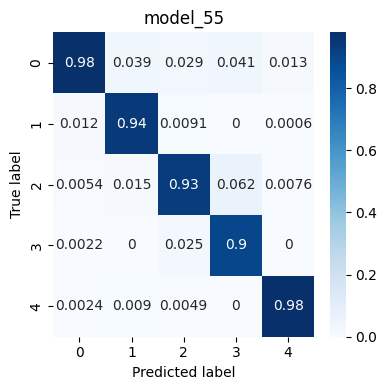

In [32]:
figure = plt.figure(figsize=(4, 4))
sns.heatmap(mat_result, annot=True,cmap=plt.cm.Blues)
plt.title(model_name)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(log_dir + '/' + model_name + '.png', pad_inches=0.1)
plt.show()